# 주식 포트폴리오를 위한 알파 팩터 구축

전문 트레이더들은 가치, 크기, 모멘텀과 같은 시장 비효율성(예: 이상 현상)을 목표로 삼고 이를 활용하여 더 나은 위험 조정 수익을 창출하기 위해 팩터 포트폴리오를 구성하곤 합니다. 이러한 특정 특성이나 팩터를 체계적으로 식별하고 이에 따라 증권의 가중치를 조정함으로써, 투자자들은 원하는 노출을 포착하는 동시에 의도하지 않은 위험을 최소화할 수 있는 포트폴리오를 만들 수 있습니다. 팩터는 투자에서 기본적인 구성 요소로 작용하며, 다양한 자산 클래스에서 수익에 지속적으로 영향을 미치는 힘입니다. 거래 우위(trading edge)란 시장에서 일관적이고 비무작위적인 비효율성을 의미하며, 이를 통해 이익을 창출할 수 있습니다. 팩터는 자산 가격을 움직이는 비효율성을 의미하며, 이러한 지속적인 이상 현상을 활용하여 트레이더가 이를 기반으로 이익을 얻을 수 있습니다.

팩터 분석은 광범위한 주제이지만, 핵심은 팩터를 식별하고 포트폴리오의 민감도를 파악하며, 이에 따라 액션을 취하는 데 있습니다. 이러한 액션은 팩터 노출에 따른 바람직하지 않은 위험을 헷지하거나 노출을 증가시키는 것을 포함합니다. 이 장에서는 팩터를 식별하고, 원하지 않는 위험을 헷지하며, 팩터의 예측력을 평가하기 위해 미래 수익을 설정하는 방법에 대해 다룹니다. Python 라이브러리를 사용하여 주성분 분석 및 선형 회귀를 구축하는 방법을 다룰 것입니다. 그 후, Zipline Reloaded Pipeline API를 소개하여 팩터 분석에 대비할 것입니다.

이 장에서는 다음 내용을 다룹니다:

- 주성분 분석을 사용하여 잠재적인 수익 동인을 식별하기  
- 선형 회귀를 사용해 포트폴리오 베타를 식별 및 헷지하기  
- Fama-French 팩터에 대한 포트폴리오 민감도 분석  
- 변동성을 기반으로 시장 비효율성 평가  
- Zipline Reloaded Pipeline API를 사용하여 팩터 순위 모델 준비  

---

## 주성분 분석을 사용하여 잠재적인 수익 동인 식별

**주성분 분석(PCA)** 은 데이터 과학에서 널리 사용되는 차원 축소 기법입니다. 이는 원래의 특징들을 주성분이라고 하는 새로운 특징들의 집합으로 변환하며, 이 주성분들은 데이터의 최대 분산을 반영합니다. 다시 말해, 큰 변수 집합을 더 작은 변수 집합으로 변환하면서도 원래 큰 집합의 대부분의 정보를 유지합니다.

자산 포트폴리오에는 시장 위험, 섹터 위험, 자산별 위험 등 다양한 위험 요소가 있습니다. PCA는 포트폴리오의 수익률을 최대 분산을 설명하는 구성요소로 분해하여 이러한 위험을 식별하고 정량화하는 데 도움을 줍니다. 처음 몇 개의 주성분이 일반적으로 대부분의 분산을 포착하며, 이를 분석하여 포트폴리오의 주요 위험 요인을 이해할 수 있습니다.


이 섹션에서는 scikit-learn을 사용하여 8개의 광산 및 기술 회사로 구성된 포트폴리오에 대해 PCA를 실행하는 방법을 다룹니다.

---

### 준비하기

이 레시피에서는 분류, 회귀, 군집화, 차원 축소 등을 위한 알고리즘을 제공하는 scikit-learn을 소개합니다. scikit-learn은 NumPy, SciPy, Matplotlib을 기반으로 하며, 다른 과학 Python 라이브러리와 쉽게 통합할 수 있습니다. 이를 사용해 분석을 수행할 것입니다.

scikit-learn을 설치하려면 다음 명령어를 실행하십시오:

```bash
pip install scikit-learn
```

---

### 실행 방법...

Scikit-learn을 사용하면 PCA를 쉽게 실행할 수 있습니다. 다음과 같이 실행하세요:

1. 분석에 필요한 라이브러리를 임포트합니다:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from openbb import obb
from sklearn.decomposition import PCA

In [2]:
obb.user.preferences.output_type = "dataframe"

2. 금광 주식과 헬스케어 주식의 데이터를 다운로드하고 일일 수익률을 계산합니다:
 
금광 및 헬스케어 주식의 심볼을 정의합니다

**광산/귀금속:**
- NEM, RGLD, SSRM, CDE (금광 채굴/로열티 기업들)

**헬스케어:**
- LLY, UNH, JNJ, MRK (제약/의료 서비스 기업들)

In [3]:
symbols = ["NEM", "RGLD", "SSRM", "CDE", "LLY", "UNH", "JNJ", "MRK"]

2020-01-01부터 2022-12-31까지 "yfinance" 제공자를 사용하여 정의된 심볼들의 과거 가격 데이터를 가져옵니다

In [4]:
data = obb.equity.price.historical(
    symbols,
    start_date="2020-01-01",
    end_date="2022-12-31",
    provider="yfinance",
).pivot(columns="symbol", values="close")

In [9]:
data.head()

symbol,CDE,JNJ,LLY,MRK,NEM,RGLD,SSRM,UNH
date,,,,,,,,
2020-01-02,7.81,145.970001,132.210007,87.824425,43.220001,121.120003,18.969999,292.500000
2020-01-03,7.70,144.279999,131.770004,87.070610,42.830002,120.129997,18.520000,289.540009
2020-01-06,6.93,144.100006,132.259995,87.442749,43.259998,118.809998,18.370001,291.549988
2020-01-07,6.89,144.979996,132.509995,85.114502,43.230000,120.180000,18.660000,289.790009
2020-01-08,6.29,144.960007,133.710007,84.541985,42.080002,111.599998,18.219999,295.899994


일일 수익률을 계산하고 결측값을 제거합니다

In [5]:
returns = data.pct_change().dropna()

3. 각 성분의 설명된 분산 비율을 추출하고 주성분을 추출합니다:

3개의 주성분으로 PCA를 초기화하고 수익률 데이터에 적용합니다

In [6]:
# random_state 매개변수를 추가하여 시드 고정
pca = PCA(n_components=3, random_state=42)
pca.fit(returns)

PCA(n_components=3, random_state=42)

설명된 분산 비율과 주성분을 추출합니다

In [7]:
pct = pca.explained_variance_ratio_
pca_components = pca.components_

In [8]:
pct

array([0.63892456, 0.13387055, 0.10157923])

In [9]:
display(pca_components)

array([[ 0.78402106,  0.06139341,  0.06157203,  0.06678106,  0.29181296,
         0.30862968,  0.42713718,  0.10216529],
       [ 0.03070356,  0.34058264,  0.60677508,  0.39052223, -0.09200527,
        -0.12445024, -0.22896855,  0.53478754],
       [ 0.6180319 , -0.10864359, -0.13197692, -0.07204876, -0.39555206,
        -0.41760383, -0.48391774, -0.13635775]])

4. 각 주성분의 기여도와 누적 설명 분산 비율을 시각화:
 
주성분의 기여도와 누적 기여도를 시각화합니다

In [10]:
cum_pct = np.cumsum(pct)
x = np.arange(1, len(pct) + 1, 1)

In [11]:
cum_pct

array([0.63892456, 0.77279511, 0.87437434])

In [12]:
x

array([1, 2, 3])

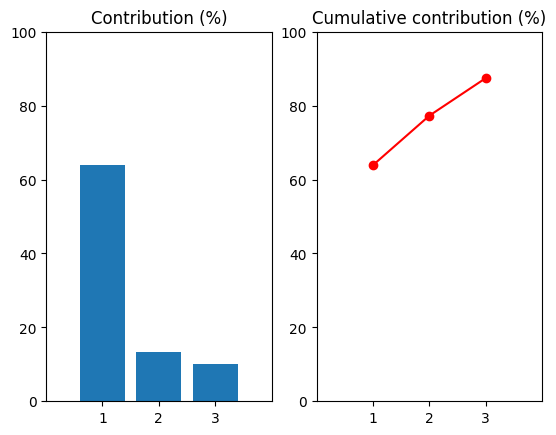

In [13]:
plt.subplot(1, 2, 1)
plt.bar(x, pct * 100, align="center")
plt.title("Contribution (%)")
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

plt.subplot(1, 2, 2)
plt.plot(x, cum_pct * 100, "ro-")
plt.title("Cumulative contribution (%)")
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

plt.show()

그림 5.1: 첫 세 개 주성분의 설명된 분산에 대한 기여도와 누적 기여도

### 작동 방식...

PCA가 어떻게 작동하는지에 대한 문서는 많이 있으므로 여기서는 수학적 과정을 다루지 않겠습니다. 

요약하자면, 
```python
PCA(n_components=3) 
```
코드는 수익률 데이터의 첫 세 개 주성분을 계산하는 PCA 객체를 생성합니다. 
```python
n_components=3 
```
매개변수는 상위 세 개의 주성분을 선택하겠다는 것을 지정합니다. 
```python
pca.fit 
```
호출은 PCA 모델을 수익률 데이터에 맞추는데, 이는 PCA의 대부분의 복잡성을 숨깁니다. 내부적으로 PCA는 수익률을 표준화하고 공분산 행렬을 계산합니다. 

다음으로, 공분산 행렬에 대해 고유값 분해가 수행되어 데이터 분산의 방향과 크기를 나타내는 고유벡터와 고유값을 계산합니다. 

마지막으로, 고유벡터들은 고유값에 따라 내림차순으로 정렬되고 상위 세 개가 주성분으로 선택됩니다.


### 더 알아보기...
 
주성분으로부터 원본 수익률 데이터를 수익률의 분산을 가장 잘 설명하는 통계적 위험 요인을 나타내는 새로운 특성 집합으로 변환할 수 있습니다. 다음 코드에서 이를 보여줍니다:
 
주성분으로부터 "통계적 위험 요인" 구성

In [14]:
# returns를 numpy 배열로 변환
X = np.asarray(returns)

# 주성분과 원본 데이터를 행렬곱하여 통계적 위험 요인 수익률 계산 
factor_returns = X.dot(pca_components.T)

# 결과를 데이터프레임으로 변환하고 각 요인에 이름 부여
factor_returns = pd.DataFrame(
    columns=["f1", "f2", "f3"], index=returns.index, data=factor_returns
)

In [31]:
display(factor_returns)

,f1,f2,f3
date,,,
2020-01-03,-0.028854,-0.007880,0.013453
2020-01-06,-0.081176,0.006441,-0.058876
2020-01-07,0.003671,-0.015563,-0.013919
2020-01-08,-0.105889,0.028154,-0.005643
2020-01-09,0.001916,0.018522,0.023465
...,...,...,...
2022-12-23,0.001576,0.007398,-0.020952
2022-12-27,0.079420,-0.010218,0.022537
2022-12-28,-0.081093,0.004814,0.005850


그림 5.2: 통계적 위험 요인들의 시계열을 포함하는 DataFrame

통계적 위험 요인들은 이 장에서 살펴볼 Fama-French 요인 분석 레시피에서 다룰 Fama-French 요인과 같은 전통적인 위험 요인들과 유사합니다. 수익률 데이터는 PCA로부터 얻은 주성분에 투영됩니다. 이는 X와 pca_components 행렬의 전치행렬의 내적을 구함으로써 이루어집니다. pca_components 행렬은 fit 메서드를 사용하여 이전에 계산된 수익률 데이터의 주성분들을 포함합니다. 이 단계는 원본 수익률 데이터를 데이터의 분산을 가장 잘 설명하는 새로운 특성 집합(주성분 또는 요인)으로 변환합니다. 

이러한 요인들은 포트폴리오의 수익이 관찰할 수 없는 통계적 특성으로부터 얼마나 영향을 받는지 이해하는데 도움을 줍니다. 

주성분을 사용하여 각 자산의 세 가지 주성분에 대한 노출도를 생성할 수 있습니다:


In [18]:
pca_components.shape

(3, 8)

In [19]:
pca_components

array([[ 0.78402106,  0.06139341,  0.06157203,  0.06678106,  0.29181296,
         0.30862968,  0.42713718,  0.10216529],
       [ 0.03070356,  0.34058264,  0.60677508,  0.39052223, -0.09200527,
        -0.12445024, -0.22896855,  0.53478754],
       [ 0.6180319 , -0.10864359, -0.13197692, -0.07204876, -0.39555206,
        -0.41760383, -0.48391774, -0.13635775]])

In [32]:
# 각 자산의 주성분에 대한 노출도를 계산하기 위해 데이터프레임 생성
# index: 각 요인(f1, f2, f3)
# columns: 각 주식 종목
# data: PCA 주성분 행렬
# .T로 전치하여 자산을 행으로, 요인을 열로 구성
factor_exposures = pd.DataFrame(
    index=["f1", "f2", "f3"], columns=returns.columns, data=pca_components
).T

결과로 나온 factor_exposures DataFrame이 다음 스크린샷에 나와 있습니다. 이는 포트폴리오의 각 자산이 세 가지 요인에 얼마나 노출되어 있는지를 보여줍니다. 각 자산의 세 가지 요인("f1", "f2", "f3")에 대한 노출도는 해당 자산의 수익률이 이러한 요인들의 변화에 얼마나 영향을 받는지를 나타냅니다.

In [33]:
display(factor_exposures)

,f1,f2,f3
symbol,,,
CDE,0.784021,0.030704,0.618032
JNJ,0.061393,0.340583,-0.108644
LLY,0.061572,0.606775,-0.131977
MRK,0.066781,0.390522,-0.072049
NEM,0.291813,-0.092005,-0.395552
RGLD,0.308630,-0.124450,-0.417604
SSRM,0.427137,-0.228969,-0.483918
UNH,0.102165,0.534788,-0.136358


그림 5.3: 각 자산의 요인별 노출도를 포함하는 DataFrame

첫 번째 주성분에 대한 요인 노출도를 그래프로 표시

<Axes: xlabel='symbol'>

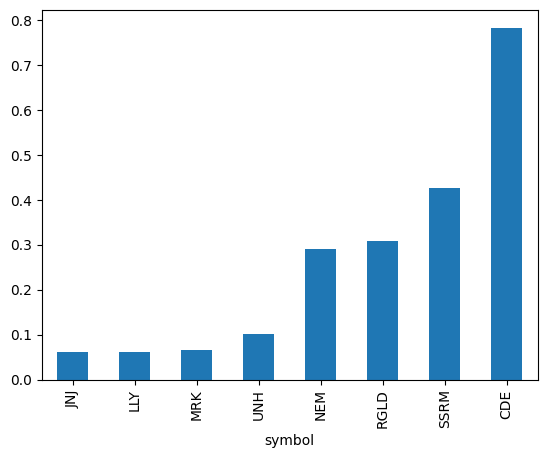

In [34]:
factor_exposures.f1.sort_values().plot.bar()

각 자산의 첫 번째와 두 번째 주성분에 대한 노출도를 주석이 달린 산점도로 시각화할 수 있습니다:

첫 번째와 두 번째 주성분의 요인 노출도에 대한 산점도

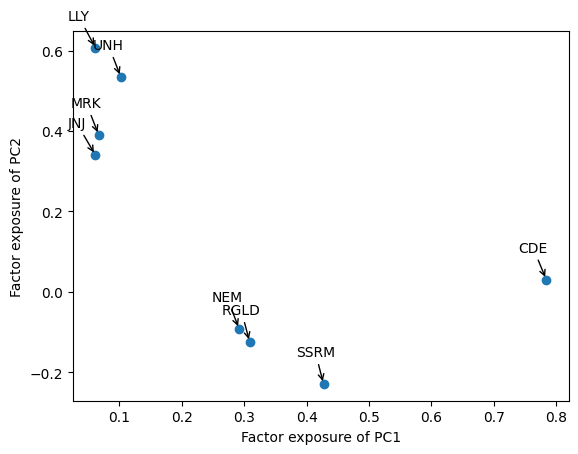

In [35]:
# 종목 레이블을 factor_exposures의 인덱스에서 가져옴
labels = factor_exposures.index
# factor_exposures의 값들을 numpy 배열로 변환
data = factor_exposures.values
# 첫 번째와 두 번째 주성분에 대한 산점도 생성
plt.scatter(data[:, 0], data[:, 1])
# x축 레이블 설정 - 첫 번째 주성분의 요인 노출도
plt.xlabel("Factor exposure of PC1") 
# y축 레이블 설정 - 두 번째 주성분의 요인 노출도
plt.ylabel("Factor exposure of PC2")

# 각 데이터 포인트에 종목 레이블과 화살표 주석 추가
for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label,  # 표시할 종목 레이블
        xy=(x, y),  # 화살표가 가리킬 좌표
        xytext=(-20, 20),  # 레이블 위치 오프셋
        textcoords="offset points",  # 오프셋 단위 지정
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),  # 화살표 스타일 설정
    )

# 그래프 표시
plt.show()

그림 5.4: 첫 번째와 두 번째 주성분에 대한 주식 노출도를 보여주는 산점도
 
금광 주식들은 헬스케어 주식들에 비해 더 높은 요인 노출도를 보이며, 이는 기초 요인들의 변화에 더 민감하다는 것을 나타냅니다. 헬스케어 주식들은 "f2"에 대해 더 낮고 음의 노출도를 보이는데, 이는 이 요인에 높은 노출도를 가진 포트폴리오에서 분산투자 효과를 제공할 수 있음을 시사합니다. 이러한 요인들은 시장 위험, 금리 위험 또는 산업별 위험과 같은 시장의 다양한 체계적 위험을 나타낼 수 있습니다.

첨부된 그래프는 금광 및 헬스케어 관련 주식 심볼의 PCA 분석 결과를 나타냅니다. 각 심볼은 두 개의 주성분(PC1, PC2)에 대한 요인 노출도(factor exposure)로 표현되었으며, 주어진 종목들에 대한 주요 인사이트는 다음과 같습니다:

---

**1. 그룹별 분포**
- **광산/귀금속 관련 주식 (NEM, RGLD, SSRM, CDE)**:
  - **CDE**는 PC1에 대해 높은 요인 노출도를 보이며, 다른 금광 관련 주식과 다소 떨어진 위치에 있습니다.
  - **NEM, RGLD**는 PC1과 PC2 모두에서 중간 정도의 노출도를 가지며, 서로 가까운 위치에 있습니다.
  - **SSRM**은 PC1에서 상대적으로 높은 노출도를 보이지만, PC2에서는 낮은 값을 가집니다.

- **헬스케어 관련 주식 (LLY, UNH, JNJ, MRK)**:
  - **LLY**는 PC2에서 가장 높은 노출도를 보이며, 다른 헬스케어 주식들과도 분리된 위치에 있습니다.
  - **UNH**와 **MRK**는 PC1에서 유사한 노출도를 보이지만, PC2에서 차이가 나타납니다.
  - **JNJ**는 PC1과 PC2 모두에서 상대적으로 중간 정도의 노출도를 보이며, 안정적인 성향을 나타낼 수 있습니다.

**2. PCA 분석 결과의 해석**
- **PC1 (주성분 1)**: 요인 노출도가 클수록 해당 주식의 특정 팩터(예: 시장 요인, 산업 요인)에 민감도가 높음을 의미합니다.  
  - **CDE**와 **SSRM**은 PC1에서 높은 노출도를 보여, 동일한 시장 요인에 더 큰 영향을 받을 가능성이 있습니다.
  
- **PC2 (주성분 2)**: 두 번째 주요 요인으로, 주식의 상관 관계에서 추가적인 분산을 설명합니다.  
  - **LLY**는 PC2에서 가장 높은 값을 보여, 다른 요인(예: 개별 주식의 고유 리스크)에 큰 영향을 받을 가능성이 큽니다.

**3. 주요 관찰**
- 금광 주식(CDE, SSRM 등)은 헬스케어 주식(LLY, UNH 등)과 명확히 분리된 클러스터를 형성하고 있으며, 이는 두 섹터가 서로 다른 요인에 의해 주도된다는 것을 시사합니다.
- 동일 섹터 내에서도 개별 주식들의 요인 노출도에는 차이가 있어, 다양한 리스크 및 수익 패턴을 반영합니다.

**분석 활용 방안**
- 투자 포트폴리오 구성 시:
  - **CDE**와 **LLY**와 같은 주식은 특정 요인에 대한 민감도가 크므로, 변동성이 더 클 가능성이 있습니다.
  - 분산 투자 전략에서는 요인 노출도가 다른 주식들을 선택해 리스크를 분산할 수 있습니다.

- 추가적인 분석:
  - PC1과 PC2 외의 추가 주성분(PC3, PC4 등)에 대한 분석을 통해 숨겨진 상관 관계를 더 깊게 탐구할 수 있습니다.
  - 시계열 데이터를 기반으로 각 주식의 요인 노출도 변화를 추적해, 시장 환경 변화에 따른 민감도를 평가할 수 있습니다.

--- 

### 참고 자료

PCA(주성분 분석)는 포트폴리오 관리에서 널리 사용되는 중요한 차원 축소 기법입니다. PCA에 대해 더 알아보려면 아래 링크를 방문하세요:

- PCA에 대한 자세한 내용: [https://en.wikipedia.org/wiki/Principal_component_analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)  
- scikit-learn 문서: [https://scikit-learn.org/stable/](https://scikit-learn.org/stable/)  
- 이 레시피에서 사용된 scikit-learn의 PCA 구현에 대한 문서: [https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)  

--- 

## 선형 회귀를 사용하여 포트폴리오 베타를 찾고 헷지하기

알고리즘 트레이더들은 종종 높은 수익을 낼 것으로 기대되는 특정 위험에 대한 노출을 추구하면서도, 불리하거나 불필요하다고 판단되는 다른 위험은 헷지하려고 합니다. 예를 들어, 트레이더는 시장 전반의 위험을 헷지하면서도 주가수익비율(P/E)이 가장 낮은 주식들에 대한 노출을 원할 수 있는데, 이는 이러한 주식들이 더 좋은 성과를 낼 것이라고 믿기 때문입니다. 이러한 선택적 노출은 특정 위험에 대한 헷지를 통해 잠재적 손실을 최소화하면서도 기회로 인식되는 부분에서 수익을 극대화하는 데 도움을 줍니다.

팩터 모델은 다른 자산, 포트폴리오 또는 팩터의 수익과 조합하여 자산 또는 포트폴리오의 수익을 설명하는 방식입니다. 선형 결합을 사용하는 팩터 모델의 일반적인 형태는 다음과 같습니다:

$
Y = \alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_n X_n
$

- **Y**: 포트폴리오/자산의 수익률
- **α**: 팩터 영향 제외한 기본 수익률
- **β**: 각 팩터에 대한 민감도 
- **X**: 시장수익률, 기업규모 등의 위험 팩터들

포트폴리오 수익의 위험 요인에 대한 민감도는 베타(β)로 설명됩니다. 헷지가 필요한 것은 바로 이 베타로, 이는 위험 요인에 대한 노출을 집중적으로 관리해야 합니다.

이 레시피에서는 **주식 포트폴리오를 구성하고, SPY 수익에 대한 포트폴리오 수익의 베타를 계산한 뒤, 시장 전반의 노출을 중립화하기 위한 헷지 포지션을 구성**할 것입니다.

---

### 준비하기

이 레시피에서는 **Statsmodels** 라이브러리를 소개합니다. 이 라이브러리는 통계 모델을 추정하고, 통계적 테스트와 데이터 탐색을 수행하기 위한 클래스와 함수를 제공합니다. 분석을 수행하기 위해 이 라이브러리를 사용할 것입니다.

Statsmodels를 설치하려면 다음 명령어를 실행하십시오:

```bash
pip install statsmodels
```

---

### 실행 방법...

Statsmodels를 사용하여 주식 포트폴리오가 벤치마크에 대해 얼마나 민감한지 측정하고, 그런 다음 헷지 베타를 상쇄하기 위해 숏 포지션을 설정할 것입니다.

1. **분석을 위한 라이브러리 불러오기**:

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from IPython.display import Markdown, display
from openbb import obb
from statsmodels import regression

In [21]:
obb.user.preferences.output_type = "dataframe"

2. **이전 레시피에서 사용한 동일한 포트폴리오의 데이터를 다운로드**:

여기에는 **SPY 상장지수펀드(ETF)** 가 포함됩니다. SPY는 시장 전반의 수익률을 나타내기 위해 사용됩니다.

In [22]:
symbols = [
    "NEM",
    "RGLD",
    "SSRM",
    "CDE",
    "LLY",
    "UNH",
    "JNJ",
    "MRK",
    "SPY",
]

2020-01-01부터 2022-12-31까지 "yfinance" 제공자를 사용하여 정의된 종목들의 과거 가격 데이터를 가져오기

In [23]:
data = obb.equity.price.historical(
    symbols,
    start_date="2020-01-01",
    end_date="2022-12-31",
    provider="yfinance",
).pivot(columns="symbol", values="close")

3. **DataFrame에서 SPY 데이터 열을 제거하고 벤치마크 수익률을 계산**:

벤치마크 "SPY"의 일일 수익률을 계산하고 결측값 제거

In [24]:
benchmark_returns = data.pop("SPY").pct_change().dropna()

4. **포트폴리오의 수익률을 계산**:

포트폴리오의 일일 수익률을 계산하고 결측값 제거

In [25]:
portfolio_returns = data.pct_change().dropna().sum(axis=1)

In [28]:
portfolio_returns

date
2020-01-03   -0.088612
2020-01-06   -0.095361
2020-01-07   -0.003813
2020-01-08   -0.185381
2020-01-09    0.007972
                ...   
2022-12-23    0.037300
2022-12-27    0.128089
2022-12-28   -0.171869
2022-12-29    0.026823
2022-12-30   -0.048973
Name: portfolio, Length: 755, dtype: float64

5. **그래프 스타일 설정**:

In [26]:
portfolio_returns.name = "portfolio"

6. **벤치마크 수익률과 포트폴리오 수익률을 시각화**:

포트폴리오와 벤치마크 일일 수익률 그래프 그리기

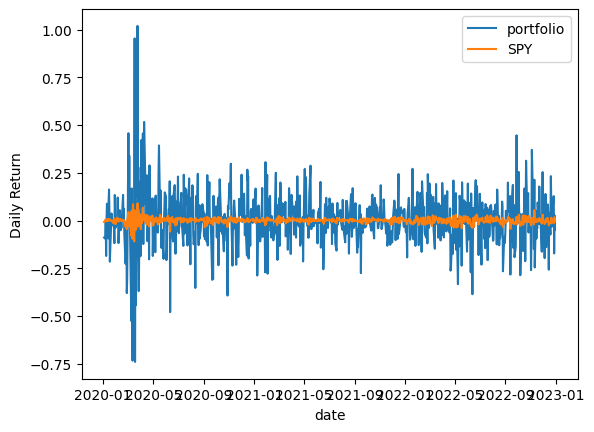

In [27]:
portfolio_returns.plot()
benchmark_returns.plot()
plt.ylabel("Daily Return")
plt.legend()
plt.show()

7. 분석 기간 동안의 일일 수익률 그래프 결과입니다:

알파와 베타를 계산하기 위한 선형 회귀 함수를 정의합니다

- Y = α + βX
    - Y: 포트폴리오 수익률
    - α: 알파 (시장 영향 제외한 초과수익률)
    - β: 시장에 대한 베타
    - X: SPY(시장) 수익률

In [29]:
def linreg(x, y):
    # 알파를 구하기 위해 1로 이루어진 열을 추가
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    
    # 모델 적합이 끝났으므로 상수항 제거
    x = x[:, 1]
    
    # 알파(절편)와 베타(기울기) 반환
    return model.params[0], model.params[1]

8. 선형 회귀에서 알파와 베타 계수를 반환하는 함수 생성:
 
포트폴리오와 벤치마크 수익률에 대해 선형 회귀를 수행하여 알파와 베타 계산

In [30]:
X = benchmark_returns.values
Y = portfolio_returns.values

9. 포트폴리오와 벤치마크 수익률 간의 회귀분석을 통해 알파와 베타 계수를 생성:

In [31]:
alpha, beta = linreg(X, Y)

In [32]:
display(f"Alpha: {alpha}")
display(f"Beta: {beta}")

'Alpha: 0.002638518577761205'

'Beta: 5.551213060083568'

10. 포트폴리오와 벤치마크 수익률 간의 선형 관계를 시각화하는 산점도 생성:
 
회귀선 그리기

In [33]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

원본 데이터 플롯

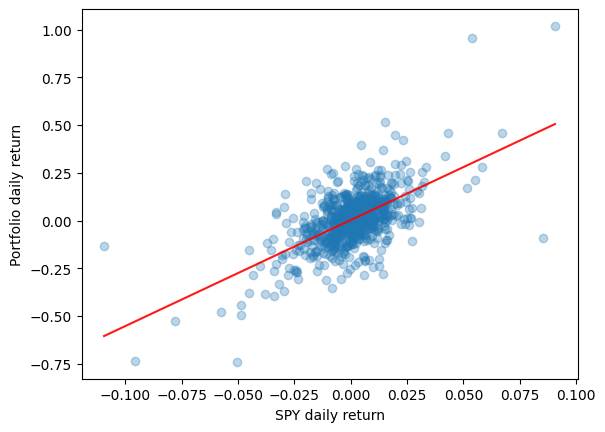

In [34]:
plt.scatter(X, Y, alpha=0.3)
plt.xlabel("SPY daily return")
plt.ylabel("Portfolio daily return")
plt.plot(X2, Y_hat, "r", alpha=0.9)
plt.show()

11. 마지막으로, 베타 헷지를 포함한 포트폴리오 수익률의 시계열을 구성합니다:
 
베타 헷징이 포함된 포트폴리오 구성

In [35]:
hedged_portfolio_returns = portfolio_returns -1 * beta * benchmark_returns
hedged_portfolio_returns

date
2020-01-03   -0.046577
2020-01-06   -0.116539
2020-01-07    0.011795
2020-01-08   -0.214967
2020-01-09   -0.029669
                ...   
2022-12-23    0.005368
2022-12-27    0.149981
2022-12-28   -0.102879
2022-12-29   -0.073100
2022-12-30   -0.034351
Length: 755, dtype: float64

12. 베타가 0인지 확인하기 위해 회귀분석을 다시 실행:
 
헷지된 포트폴리오 수익률과 벤치마크 수익률에 대해 선형 회귀를 수행하여 알파와 베타 계산

In [36]:
P = hedged_portfolio_returns.values
alpha, beta = linreg(X, P)

In [37]:
display(f"Alpha: {alpha}")
display(f"Beta: {beta}")

'Alpha: 0.002638518577761207'

'Beta: -3.2674600872195647e-15'

---

### **작동 방식...**

베타 헷지를 설명하기 위해, 우리는 8개의 주식으로 구성된 포트폴리오의 일일 수익률을 합산하여 각 일의 데이터를 만듭니다. 우리는 S&P 500 추적 ETF를 더 넓은 시장의 대리로 사용하며, ETF 심볼은 **SPY**입니다. 포트폴리오 데이터와 함께 SPY의 가격 데이터를 다운로드하고, SPY 열을 별도의 시리즈로 처리합니다. 그런 다음, 포트폴리오와 벤치마크 모두의 일일 수익률을 계산합니다.

다음 단계는 몇 줄의 코드로 선형 회귀를 실행하는 것입니다. $ x $는 독립 변수로 벤치마크 수익률을 나타내고, $ y $는 종속 변수로 포트폴리오 수익률을 나타냅니다. `linreg` 함수는 이러한 수익률을 받아 $ x $에 상수 항(intercept)을 추가한 다음, 일반 최소 제곱 회귀(OLS)를 사용해 선형 모델을 맞춥니다. 이 함수는 적합된 모델의 매개변수(즉, 절편 $ \alpha $와 기울기 $ \beta $)를 반환합니다.

>**중요한 주의 사항**
>
>상수 항(intercept)을 추가하는 것은 선형 회귀에서 종속 변수와 독립 변수 간의 관계를 정확히 모델링하기 위해 매우 중요합니다. 상수 항을 포함하지 않으면, 회귀선을 원점(0, 0)을 지나도록 강제하는 결과를 낳게 되어, 변수 간 관계를 부정확하게 나타낼 수 있습니다.

절편(Alpha) 및 베타(Beta) 항목을 얻은 후, 헷지된 포트폴리오를 구축할 수 있습니다. 이 레시피의 서론에서 배운 것처럼, 트레이더는 원하지 않는 위험에 대한 노출을 헷지합니다. 만약 포트폴리오 수익률이 선형 관계를 통해 특정 위험 요인에 연결되어 있다고 판단된다면, 우리는 해당 위험 요인에 숏 포지션을 시작할 수 있습니다. 여기서는 SPY로 대표되는 더 넓은 시장이 그 위험 요인입니다. 우리가 거래하려는 금액은 베타에 의해 결정됩니다. 이는 효과적입니다. 왜냐하면 만약 우리의 수익이 $ \alpha + \beta_{SPY} $로 구성되어 있다면, SPY에 대한 숏 포지션을 취하면 우리의 새로운 수익은 $ \alpha + \beta_{SPY} - \beta_{SPY} = \alpha $가 되기 때문입니다.

우리는 회귀를 다시 실행하여 헷지된 포트폴리오의 베타가 0임을 검증합니다.

---

### **더 알아보기...**

정보 비율(Information Ratio)은 거래 전략의 위험 조정 수익 성과를 평가하는 데 사용되는 지표입니다. 이는 포트폴리오의 능동적 수익(포트폴리오 수익과 벤치마크 수익의 차이)을 능동적 위험(능동적 수익의 표준편차)으로 나눈 값으로 계산됩니다. 정보 비율은 두 포트폴리오를 벤치마크와 비교하는 데 유용한 방법입니다. 다음은 이를 계산하는 함수를 작성한 코드입니다:

정보 비율을 계산하는 함수 정의

In [38]:
def information_ratio(portfolio_returns, benchmark_returns):
    """
    전략의 정보 비율을 계산합니다.

    매개변수
    ----------
    portfolio_returns : pd.Series or np.ndarray
        전략의 일일 수익률 (비누적)
    benchmark_returns : int, float
        벤치마크 또는 요인의 일일 수익률 (비누적)
    반환값
    -------
    information_ratio : float
        정보 비율
    참고
    -----
    자세한 내용은 https://pyquantnews.com/how-to-measure-skill-portfolio-manager/ 참조
    """

    # 초과 수익률 계산 (포트폴리오 수익률 - 벤치마크 수익률)
    active_return = portfolio_returns - benchmark_returns
    
    # 추적 오차 계산 (초과 수익률의 표준편차)
    tracking_error = active_return.std()
    
    # 정보 비율 = 평균 초과 수익률 / 추적 오차
    return active_return.mean() / tracking_error

다음으로, 정보 비율을 사용하여 헷지된 포트폴리오와 헷지되지 않은 포트폴리오의 차이를 비교해 보겠습니다:

헷지된 포트폴리오와 헷지되지 않은 포트폴리오의 정보 비율 계산

In [39]:
hedged_ir = information_ratio(hedged_portfolio_returns, benchmark_returns)

In [40]:
unhedged_ir = information_ratio(portfolio_returns, benchmark_returns)

In [41]:
display(f"Hedged information ratio: {hedged_ir}")
display(f"Unhedged information ratio: {unhedged_ir}")

'Hedged information ratio: 0.019857076696277624'

'Unhedged information ratio: 0.030991554126598382'

위 코드를 실행하면, 헷지되지 않은 포트폴리오가 더 낮은 위험 조정 수익을 가진다는 결과가 나타납니다. 이는 벤치마크에 기인한 수익이 헷지된 결과이므로 예상되는 결과입니다.

---

해당 결과를 분석해보겠습니다:

1. **헷지된 포트폴리오 (IR = 0.0199)**
- 시장 위험이 제거된(헷지된) 포트폴리오
- 매우 낮은 양의 IR 값
- 위험 조정 수익이 거의 0에 가까움

2. **헷지되지 않은 포트폴리오 (IR = 0.0310)**
- 시장 위험에 노출된 포트폴리오
- 상대적으로 더 높은 IR 값이지만, 여전히 매우 낮음
- 위험 조정 수익이 약간 더 높음

3. **해석의 근거**:
````python
# 헷지된 포트폴리오
IR_hedged = 0.0199
# 헷지되지 않은 포트폴리오
IR_unhedged = 0.0310

# 두 포트폴리오 모두 IR < 0.5로 저조한 성과
# 하지만 헷지되지 않은 포트폴리오가 약간 더 나은 성과
difference = IR_unhedged - IR_hedged  # = 0.0111
````

4. **중요한 점**:
- 두 IR 값 모두 매우 낮음 (0.5 미만)
- 헷지가 오히려 성과를 약간 낮춤
- 이는 해당 기간 동안 시장 베타 노출이 포트폴리오에 긍정적 영향을 미쳤음을 시사

5. **실무적 의미**:
- 이 기간 동안에는 헷지 전략이 효과적이지 않았음
- 시장 노출(베타)이 오히려 약간의 추가 수익을 제공
- 두 전략 모두 매우 저조한 위험조정 수익률을 보임

---

### **참고 자료**

헷지는 적절한 위험 관리를 위한 중요한 부분이며 성공적인 거래의 핵심입니다. 포트폴리오 수익과 요인 수익 간의 단순한 선형 관계를 사용하여 원하지 않는 위험을 중립화하는 것은 훌륭한 방법입니다. 이 레시피에서 다룬 주제에 대해 더 자세히 알아보려면 아래 링크를 참조하십시오:

- Statsmodels의 일반 최소 제곱(OLS) 설명: [https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html](https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html)
- 포트폴리오 관리 및 거래에서 베타 사용법: [https://www.investopedia.com/terms/b/beta.asp](https://www.investopedia.com/terms/b/beta.asp)
- 정보 비율 계산 방법: [https://pyquantnews.com/how-to-measure-skill-portfolio-manager/](https://pyquantnews.com/how-to-measure-skill-portfolio-manager/)

--- 

## Fama-French 요인에 대한 포트폴리오 민감도 분석

Fama-French 요인은 주식 수익률의 변화를 설명하기 위해 경제학자 Eugene F. Fama와 Kenneth R. French가 정의한 요인 집합입니다. 이러한 요인은 Fama-French 3요인 모델의 기초가 됩니다. **1장, Cutting-edge Python Libraries를 사용한 무료 금융 시장 데이터 획득**에서는 pandas_datareader를 사용하여 Fama-French 요인 데이터를 다운로드하는 방법을 배웠습니다.

이 레시피에서는 포트폴리오가 크기(size)와 시장 가치(market value) 요인에 노출되는 정도를 계산합니다.

---

### 준비하기

**1장, Cutting-edge Python Libraries를 사용한 무료 금융 시장 데이터 획득**에서 pandas_datareader가 설치되어 있어야 합니다. 설치되지 않았다면 다음 명령어로 설치할 수 있습니다:

```bash
pip install pandas_datareader
```

또한, 이전 레시피에서 생성된 과거 가격 데이터를 포함한 `data` 데이터프레임이 있다고 가정합니다.

---

### 실행 방법...

이전 레시피에서 학습한 베타를 사용하여 요인 민감도를 계산하는 방법을 재사용합니다.

1. 분석에 필요한 라이브러리 가져오기

In [42]:
import warnings

In [43]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import statsmodels.api as sm
from IPython.display import Markdown, display
from openbb import obb
from statsmodels import regression
from statsmodels.regression.rolling import RollingOLS

In [44]:
warnings.filterwarnings("ignore")
obb.user.preferences.output_type = "dataframe"

벤치마크 "SPY"를 포함한 주식 종목 정의

In [50]:
symbols = ["NEM", "RGLD", "SSRM", "CDE", "LLY", "UNH", "JNJ", "MRK", "SPY"]

2015-01-01부터 2022-12-31까지 정의된 심볼(Symbol)의 과거 가격 데이터를 "yfinance" 제공자를 사용하여 가져오세요.

In [51]:
data = obb.equity.price.historical(
    symbols,
    start_date="2015-01-01",
    end_date="2022-12-31",
    provider="yfinance",
).pivot(columns="symbol", values="close")

In [52]:
display(data)

symbol,CDE,JNJ,LLY,MRK,NEM,RGLD,SPY,SSRM,UNH
date,,,,,,,,,
2015-01-02,5.30,104.519997,70.059998,54.570610,19.340000,64.309998,205.429993,5.28,100.779999
2015-01-05,5.44,103.790001,69.370003,55.381680,19.459999,65.849998,201.720001,5.41,99.120003
2015-01-06,5.69,103.279999,69.720001,57.557251,20.270000,66.930000,199.820007,5.85,98.919998
2015-01-07,5.61,105.559998,69.230003,58.788170,20.090000,66.070000,202.309998,5.67,99.930000
2015-01-08,5.60,106.389999,70.870003,59.971375,19.980000,65.419998,205.899994,5.51,104.699997
...,...,...,...,...,...,...,...,...,...
2022-12-23,3.43,177.479996,367.899994,111.860001,47.849998,112.839996,382.910004,15.95,531.309998
2022-12-27,3.69,177.429993,364.880005,112.120003,48.750000,114.410004,381.399994,16.34,531.989990
2022-12-28,3.47,176.660004,365.220001,111.080002,47.369999,111.500000,376.660004,15.70,528.450012


2. 일별 수익률 데이터를 월별로 변환
`asfreq`를 사용하여 데이터를 월별로 리샘플링하고, `to_period`를 사용하여 행 레이블을 월별 형식으로 교체합니다. 이는 Fama-French 요인 데이터와 동일한 형식입니다. 일관된 형식은 이후 데이터를 동일한 데이터프레임으로 정렬할 수 있게 합니다:

월별 수익률을 계산하고 인덱스를 월별 기간으로 변환

---

1. `asfreq("ME")`:
- 시계열 데이터의 **샘플링 빈도**를 변경합니다
- 각 월의 마지막 날짜의 데이터만 선택합니다
- 결과는 여전히 구체적인 날짜(예: 2023-01-31, 2023-02-28 등)를 인덱스로 가집니다

2. `to_period("M")`:
- 날짜 인덱스의 **형식**을 변경합니다
- 구체적인 날짜를 월 단위 기간으로 변환합니다
- 예: '2023-01-31' → '2023-01'

예시로 보면:
```python
# 원본 데이터
2023-01-15    100
2023-01-31    110
2023-02-15    120
2023-02-28    130

# asfreq("ME") 적용 후
2023-01-31    110
2023-02-28    130

# to_period("M") 추가 적용 후
2023-01    110
2023-02    130
```

이렇게 두 메서드를 순차적으로 사용하는 이유는:
1. 먼저 월말 데이터만 추출하고
2. 그 다음 날짜 형식을 월 단위로 단순화하여
3. Fama-French 데이터와 같은 월별 데이터와 쉽게 매칭할 수 있게 하기 위함입니다

---

In [53]:
monthly_returns = data.asfreq("ME").pct_change(fill_method=None).to_period("M")

3. 결과
결과는 Fama-French 월별 요인 데이터와 정렬하기 적합한 월별 수익률을 포함한 데이터프레임입니다.

In [54]:
display(monthly_returns)

symbol,CDE,JNJ,LLY,MRK,NEM,RGLD,SPY,SSRM,UNH
date,,,,,,,,,
2015-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04,0.108280,-0.013917,-0.010736,0.036187,0.220175,0.022500,0.009834,0.203090,-0.058247
2015-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09,0.239130,0.012520,0.073432,0.008903,0.016199,0.020892,-0.096159,0.090437,-0.027516


4. 활성 수익률 계산

활성 수익률을 계산하여 종속 변수로 사용합니다. 이를 통해 Fama-French 요인이 활성 수익률에 미치는 민감도를 이해할 수 있습니다:
- 활성 수익률 : 포트폴리오 매니저의 투자 결정으로 인해 발생한 초과 수익률을 의미

In [55]:
# SPY를 벤치마크로 사용하기 위해 monthly_returns에서 분리
bench = monthly_returns.pop("SPY")

# 포트폴리오 수익률 계산 (각 종목의 동일가중 평균)
R = monthly_returns.mean(axis=1)

# 활성 수익률 계산 (포트폴리오 수익률 - 벤치마크 수익률)
# dropna()로 결측치 제거
active = (R - bench).dropna()

display(active)

date
2015-04    0.053583
2015-07   -0.127758
2015-08    0.036049
2015-09   -0.007283
2015-12    0.026709
2016-03    0.027287
2016-06    0.195547
2016-09    0.015746
2016-10   -0.040457
2016-11   -0.076670
2017-02   -0.053863
2017-03   -0.008057
2017-06   -0.004521
2017-07    0.012207
2017-08    0.029219
2017-11   -0.030806
2018-02   -0.023981
2018-05   -0.012595
2018-08   -0.084230
2018-11    0.007891
2018-12    0.119917
2019-01   -0.027921
2019-02   -0.029606
2019-05    0.043535
2019-10    0.025727
2020-01   -0.046278
2020-04    0.125764
2020-07    0.059689
2020-08   -0.064567
2020-09   -0.020517
2020-12    0.072391
2021-04   -0.042029
2021-09   -0.038899
2021-12    0.009838
2022-01    0.016856
2022-02    0.068695
2022-03    0.073874
2022-06    0.025464
2022-09    0.150409
2022-10   -0.016084
2022-11    0.000897
Freq: M, dtype: float64

5. pandas_datareader를 사용하여 Fama-French 데이터 다운로드

Fama-French 요인 데이터 가져오기

In [56]:
# Fama-French 요인 데이터를 가져옵니다
# F-F_Research_Data_Factors 데이터셋에서 2015년부터 2022년까지의 데이터를 가져옵니다
# 데이터는 퍼센트 단위이므로 100으로 나누어 소수점으로 변환합니다
factors = (
    pdr.get_data_famafrench(
        "F-F_Research_Data_Factors", 
        start="2015-01-01",
        end="2022-12-31",
    )[0][1:] 
    / 100
)

# active 수익률과 동일한 인덱스를 가진 SMB, HML 요인을 추출합니다
# SMB(Small Minus Big): 시가총액이 작은 기업과 큰 기업의 수익률 차이를 나타내는 요인
# HML(High Minus Low): 장부가치 대비 시장가치 비율이 높은 기업과 낮은 기업의 수익률 차이를 나타내는 요인
SMB = factors.loc[active.index, "SMB"]
HML = factors.loc[active.index, "HML"]

In [57]:
help(pdr.get_data_famafrench)

Help on function get_data_famafrench in module pandas_datareader.data:

get_data_famafrench(*args, **kwargs)



6. 공통 날짜 인덱스에 따라 데이터를 정렬하여 pandas DataFrame 생성

활성 수익률과 Fama-French 요인으로 DataFrame 생성

In [58]:
# 활성 수익률과 Fama-French 요인으로 DataFrame 생성
# R: 활성 수익률 (포트폴리오 수익률 - 벤치마크 수익률)
# SMB: 규모 요인 (Small Minus Big)
# HML: 가치 요인 (High Minus Low)
df = pd.DataFrame(
    {
        "R": active,
        "SMB": SMB,
        "HML": HML,
    },
    index=active.index,
).dropna()

7. 회귀 실행 및 요인별 베타 계수 도출

회귀를 실행하여 각 요인에 대한 베타 계수를 얻습니다. 이러한 계수는 활성 수익률이 Fama-French 요인에 얼마나 노출되어 있는지를 나타냅니다:

활성 수익률의 요인별 민감도를 추정하기 위해 선형 회귀 수행

In [59]:
b1, b2 = regression.linear_model.OLS(df.R, df[["SMB", "HML"]]).fit().params

In [64]:
print(f"Sensitivities of active returns to factors:\nSMB: {b1}\nHML: {b2}")

Sensitivities of active returns to factors:
SMB: 0.0876106742871349
HML: -0.026381516925070413


---

이 결과는 활성 수익률(Active Returns)이 Fama-French 요인들에 대해 가지는 민감도(베타)를 보여줍니다:

1. **SMB (Small Minus Big) 민감도: 0.0876**
- **의미**: 소형주 프리미엄에 대한 양의 노출도
- **해석**: 
  - 포트폴리오가 대형주보다 소형주의 성과에 더 민감함
  - SMB가 1% 상승할 때 포트폴리오는 약 0.0876% 상승하는 경향
  - 상대적으로 작은 값이므로 SMB 요인에 대한 노출도는 제한적

2. **HML (High Minus Low) 민감도: -0.0264**
- **의미**: 가치주 프리미엄에 대한 음의 노출도
- **해석**:
  - 포트폴리오가 가치주보다 성장주의 성과에 더 민감함
    - **H(High)**: 장부가치/시장가치 비율이 높은 주식들 = 가치주
    - **L(Low)**: 장부가치/시장가치 비율이 낮은 주식들 = 성장주  
  - HML이 1% 상승할 때 포트폴리오는 약 0.0264% 하락하는 경향
  - 매우 작은 음수 값이므로 HML 요인에 대한 노출도는 미미함

3. **전반적 분석**:
- 두 요인 모두에 대한 민감도가 낮음 (절대값 < 0.1)
- 포트폴리오가 이러한 전통적인 요인들에 크게 영향받지 않음
- 수익률의 대부분이 다른 요인들에 의해 설명될 가능성이 높음

4. **투자 전략에 대한 시사점**:
- 요인 노출도가 낮아 시장 중립적인 포트폴리오로 볼 수 있음
- 다른 알파 소스를 찾아볼 필요가 있음
- 위험 관리 측면에서 안정적인 구조를 가짐

---


8. 민감도의 시간 경과에 따른 변화 시각화

Statsmodels의 `RollingOLS` 클래스를 사용하여 민감도의 시간적 변화를 확인합니다:

시간에 따라 변화하는 민감도를 추정하기 위해 롤링 회귀 수행

이 결과는 12개월 이동 회귀를 시간에 따라 플롯하고, 95% 신뢰 구간을 포함하는 두 개의 차트를 생성합니다.

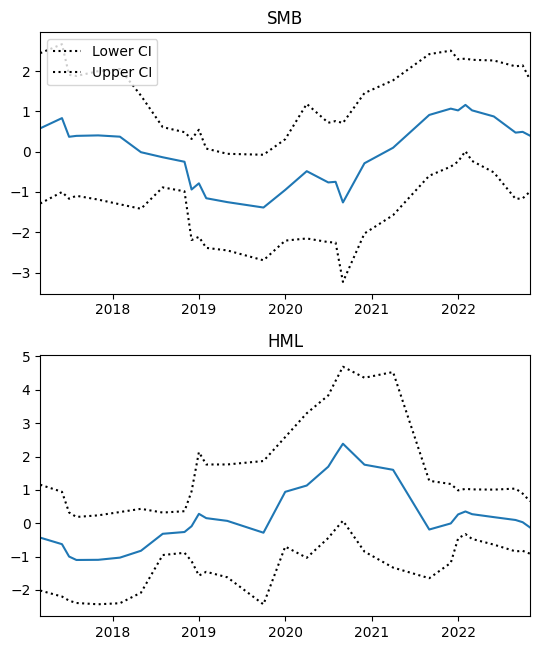

In [65]:
# SMB와 HML 요인에 상수항 추가
exog = sm.add_constant(df[["SMB", "HML"]])

# 12개월 윈도우로 롤링 OLS 회귀 수행
rols = RollingOLS(active, exog, window=12)
rres = rols.fit()

# SMB와 HML 요인의 회귀계수 시각화 
fig = rres.plot_recursive_coefficient(variables=["SMB", "HML"], figsize=(5.5, 6.6))

---

### 작동 방식...

OpenBB를 사용하여 금융 시장 데이터를 다운로드하고 포트폴리오 수익률을 계산하는 절차는 이 장의 **"Finding and hedging portfolio beta using linear regression"** 레시피와 동일합니다. Fama-French 요인 데이터는 월별 데이터로 제공되므로, `asfreq`와 `to_period`를 사용하여 가격 데이터를 월별로 리샘플링하고 월별 수익률을 계산합니다.

그다음, 포트폴리오 수익률 중 시장의 전체 움직임에 기인하지 않고 포트폴리오 관리 결정의 결과로 발생하는 부분인 **활성 수익률(active returns)** 을 계산합니다. 투자 요인은 서로 다른 증권 간 수익률 차이를 설명하는 체계적 위험 요인으로, 포트폴리오의 활성 수익률은 이러한 요인에 대한 노출도에 의해 영향을 받을 수 있습니다.

노출도를 측정하기 위해 Statsmodels 라이브러리의 `OLS` 메서드를 사용하여 선형 회귀 모델을 적합하고 요인의 베타 계수를 계산합니다. 종속 변수는 포트폴리오의 활성 수익률을 나타내는 `df.R`이며, 독립 변수는 Fama-French 3요인 모델의 **Small Minus Big (SMB)** 요인과 **High Minus Low (HML)** 요인을 나타내는 `df["SMB"]`와 `df["HML"]`입니다. `fit` 메서드는 이 모델의 매개변수를 추정하는 데 사용되며, 여기서 매개변수는 `b1`과 `b2`에 저장된 SMB 및 HML 요인의 베타 값입니다.

노출도가 시간에 따라 어떻게 변화하는지 이해하기 위해, Statsmodels의 `RollingOLS` 클래스를 사용하여 **롤링 회귀(rolling regression)** 를 빌드합니다. SMB와 HML 요인에 대한 절편(intercept)을 추가한 상수 열로 외생 변수를 생성하고, 이 클래스에 12개월의 윈도우 크기를 지정합니다. 그런 다음, `fit` 메서드를 호출하여 롤링 OLS 추정치를 계산합니다. 마지막으로 `plot_recursive_coefficient` 메서드를 사용하여 12개월 기간 동안 SMB와 HML의 회귀 계수 추정치를 시각화하는 플롯을 생성합니다.

---

### 더 알아보기...

**활성 위험에 대한 한계 기여도(MCAR)** 는 각 요인이 포트폴리오에 추가하는 추가 활성 위험의 양을 정량화합니다. 요인의 MCAR을 계산하려면, 요인 민감도를 요인 간 공분산으로 곱하고 이를 활성 수익률의 표준 편차 제곱으로 나눕니다. 이 계산은 포트폴리오 내 이미 존재하는 다른 요인에 대한 노출을 고려하여 각 요인에 노출됨으로써 발생하는 위험의 양을 보여줍니다. 설명되지 않은 위험 기여도는 분석 중인 요인 외의 요인에 대한 노출입니다.

활성 위험에 대한 한계 기여도(MCAR) 추정

In [66]:
# SMB와 HML 요인 데이터 추출
F1 = df.SMB  # SMB(Small Minus Big) 요인
F2 = df.HML  # HML(High Minus Low) 요인

# 두 요인 간의 공분산 행렬 계산
cov = np.cov(F1, F2)
cov

array([[ 0.00069803, -0.00010169],
       [-0.00010169,  0.00142598]])

In [68]:
# 활성 수익률의 분산 계산
ar_squared = (active.std()) ** 2

# SMB 요인의 한계 위험 기여도 계산
# b1(SMB 베타)와 b2(HML 베타)를 사용하여 교차 효과 고려
mcar1 = (b1 * (b2 * cov[0, 1] + b1 * cov[0, 0])) / ar_squared

# HML 요인의 한계 위험 기여도 계산
mcar2 = (b2 * (b1 * cov[0, 1] + b2 * cov[1, 1])) / ar_squared

In [69]:
display(f"SMB risk contribution: {mcar1}")
display(f"HML risk contribution: {mcar2}")
display(f"Unexplained risk contribution: {1 - (mcar1 + mcar2)}")

'SMB risk contribution: 0.0013691270661885548'

'HML risk contribution: 0.0003004883012588715'

'Unexplained risk contribution: 0.9983303846325525'

이 코드를 실행하면, 이 두 요인에 의해 설명되는 위험이 약 0.7%에 불과하다는 것을 알 수 있습니다. 이제 시간에 따른 요인의 MCAR을 플롯해 보겠습니다.

---
**주어진 결과**:
1. **SMB의 위험 기여도 (mcar1)**:  
   - **0.00137 (약 0.137%)**
   - 포트폴리오 활성 위험에서 **SMB 요인(소형주와 대형주의 수익률 차이)**가 차지하는 비율.  
   - SMB 요인이 포트폴리오의 활성 위험에 매우 낮은 기여도를 보임.

2. **HML의 위험 기여도 (mcar2)**:  
   - **0.00030 (약 0.03%)**  
   - 포트폴리오 활성 위험에서 **HML 요인(고시장가치와 저시장가치의 수익률 차이)**가 차지하는 비율.  
   - HML 역시 포트폴리오 활성 위험에 거의 영향을 미치지 않음.

3. **설명되지 않은 위험 기여도**:  
   - **0.99833 (약 99.83%)**
   - 포트폴리오 활성 위험의 대부분이 **SMB와 HML 요인 이외의 요인**에 의해 발생.  
   - 이 값은 포트폴리오가 SMB와 HML 요인에 크게 민감하지 않거나, 설명되지 않은 요인에 의한 위험이 매우 크다는 것을 의미.

---

**MCAR 계산 단계**

1. 요인 간 12개월 이동 공분산 계산:

롤링 공분산과 활성 위험 제곱 계산

In [71]:
covariances = (df[["SMB", "HML"]].rolling(window=12).cov()).dropna()

2. 12개월 이동 활성 수익률 제곱 계산:

In [72]:
active_risk_squared = (active.rolling(window=12).std() ** 2).dropna()

3. 이동 요인 베타 결합:

롤링 베타를 계산하세요.

```python

# SMB와 HML 요인에 상수항 추가
exog = sm.add_constant(df[["SMB", "HML"]])

# 12개월 윈도우로 롤링 OLS 회귀 수행
rols = RollingOLS(active, exog, window=12)
rres = rols.fit()

```
에서 가지고 옴

In [73]:
betas = pd.concat([rres.params.SMB, rres.params.HML], axis=1).dropna()

4. 롤링 MCAR 데이터를 저장할 빈 데이터프레임 생성:

MCAR 추정치를 저장할 데이터프레임 생성

In [74]:
MCAR = pd.DataFrame(index=betas.index, columns=betas.columns)

In [75]:
MCAR

,SMB,HML
date,,
2017-03,NaN,NaN
2017-06,NaN,NaN
2017-07,NaN,NaN
2017-08,NaN,NaN
2017-11,NaN,NaN
2018-02,NaN,NaN
2018-05,NaN,NaN
2018-08,NaN,NaN
2018-11,NaN,NaN


5. 각 요인과 각 날짜에 대해 MCAR 값 계산:

각 시점에서 각 요인에 대한 MCAR 계산

In [76]:
for factor in betas.columns:
    for t in betas.index:
        # 베타와 공분산의 합 계산
        s = np.sum(betas.loc[t] * covariances.loc[t][factor])
        # 베타 값 가져오기 
        b = betas.loc[t][factor]
        # 활성 위험의 제곱 가져오기
        AR = active_risk_squared.loc[t]
        # 모든 값을 결합하여 해당 날짜의 FMCAR 추정
        MCAR[factor][t] = b * s / AR

6. 각 요인에 대한 MCAR을 플롯:

각 요인에 대한 MCAR 추정치와 설명되지 않은 위험 기여도를 플롯

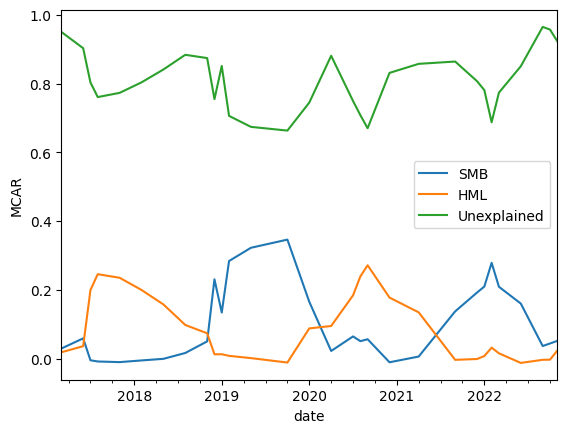

In [79]:
MCAR.SMB.plot(label='SMB')
MCAR.HML.plot(label='HML')
(1 - (MCAR.SMB + MCAR.HML)).plot(label='Unexplained')
plt.legend()
plt.xlabel('date')
plt.ylabel('MCAR')
plt.show()

---

### 참가 자료

특정 요인 특성을 가진 증권을 체계적으로 선택함으로써, 투자자들은 더 넓은 시장이나 특정 벤치마크에 비해 더 나은 위험 조정 수익률을 달성하는 것을 목표로 합니다. 요인 투자는 광범위하고 심층적인 주제입니다. 요인 투자에 대해 더 알아보려면 아래 링크를 참조하세요:

- [BlackRock의 요인 투자 소개](https://www.blackrock.com/us/individual/investment-ideas/what-is-factor-investing)
- Richard Grinold와 Ronald Kahn의 **Advances in Active Portfolio Management**는 포트폴리오 구성, 위험 관리, 실행과 같은 주제를 포함하여 능동적 포트폴리오 관리의 정량적 측면을 깊이 다룬 고급 가이드입니다: [링크로 이동](https://amzn.to/44zJeMk)

---

## 변동성을 기반으로 시장 비효율성 평가

변동성을 요인으로 사용하는 것은 변동성이 큰 주식의 가격 책정과 관련된 시장 비효율성을 반영합니다. 역사적으로, 낮은 변동성을 가진 주식은 위험 조정 기준에서 높은 변동성을 가진 주식보다 더 나은 성과를 내는 경향이 있었습니다. 이 현상은 높은 위험은 더 높은 수익으로 보상받아야 한다는 전통적인 금융 이론에 모순되며, 시장 비효율성을 나타냅니다.

요인의 성과를 분석하는 첫 번째 단계 중 하나는 미래 수익률을 계산하는 것입니다. 미래 수익률은 특정 시점 이후의 증권 수익률을 말합니다. 미래 수익률이 계산되면, 스피어만 순위 상관계수를 사용하여 요인과 미래 수익률 간의 관계를 이해할 수 있습니다. 스피어만 순위 상관계수는 두 변수 간의 관계가 단조 함수로 설명될 수 있는 정도를 평가합니다. 높은 스피어만 순위 상관계수는 요인이 증권의 순위를 미래 수익률 순위와 밀접하게 일치하도록 매기고 있음을 나타내며, 이는 요인이 예측력을 가진다는 것을 시사합니다. 반대로 낮은 스피어만 순위 상관계수는 요인이 미래 수익률을 예측하기에 적합하지 않음을 나타냅니다.

파킨슨 추정기는 특정 기간 동안의 고가와 저가를 사용하여 변동성을 보다 정확하게 측정합니다. 기본 아이디어는 고가와 저가가 종가보다 가격 움직임에 대한 더 많은 정보를 포함한다는 것입니다. 이 레시피에서는 파킨슨 변동성을 사용하여 요인을 만들고, 미래 수익률을 계산하며, 요인과 미래 수익률 간의 스피어만 순위 상관계수를 결정합니다.

---

### 실행 방법...

파킨슨 변동성과 미래 수익률을 계산하여 이를 거래 가능 요인으로서의 예측력을 측정합니다.

1. 분석에 사용할 라이브러리 가져오기

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from openbb import obb
from scipy.stats import spearmanr

In [117]:
obb.user.preferences.output_type = "dataframe"

2. OpenBB를 사용하여 데이터 다운로드

주식 심볼 정의

In [118]:
symbols = ["NEM", "RGLD", "SSRM", "CDE", "LLY", "UNH", "JNJ", "MRK"]

"yfinance" 제공자를 사용하여 2015-01-01부터 2022-12-31까지 정의된 심볼들의 과거 가격 데이터를 가져오기

In [119]:
data = obb.equity.price.historical(
    symbols, start_date="2015-01-01", end_date="2022-12-31", provider="yfinance"
)

In [120]:
display(data)

,open,high,low,close,volume,split_ratio,dividend,symbol
date,,,,,,,,
2015-01-02,5.020000,5.300000,4.960000,5.300000,2864400,0.0,0.0,CDE
2015-01-02,105.050003,105.550003,104.129997,104.519997,5753600,0.0,0.0,JNJ
2015-01-02,69.769997,70.820000,69.720001,70.059998,3146200,0.0,0.0,LLY
2015-01-02,54.599236,55.143131,54.417938,54.570610,7415962,0.0,0.0,MRK
2015-01-02,18.650000,19.389999,18.600000,19.340000,6533500,0.0,0.0,NEM
...,...,...,...,...,...,...,...,...
2022-12-30,111.230003,111.419998,110.120003,110.949997,5498600,0.0,0.0,MRK
2022-12-30,47.590000,47.599998,46.650002,47.200001,3921900,0.0,0.0,NEM
2022-12-30,112.650002,112.949997,111.500000,112.720001,302900,0.0,0.0,RGLD


데이터에서 관련 열 선택

In [121]:
prices = data[["high", "low", "close", "volume", "symbol"]]

In [122]:
display(prices)

,high,low,close,volume,symbol
date,,,,,
2015-01-02,5.300000,4.960000,5.300000,2864400,CDE
2015-01-02,105.550003,104.129997,104.519997,5753600,JNJ
2015-01-02,70.820000,69.720001,70.059998,3146200,LLY
2015-01-02,55.143131,54.417938,54.570610,7415962,MRK
2015-01-02,19.389999,18.600000,19.340000,6533500,NEM
...,...,...,...,...,...
2022-12-30,111.419998,110.120003,110.949997,5498600,MRK
2022-12-30,47.599998,46.650002,47.200001,3921900,NEM
2022-12-30,112.949997,111.500000,112.720001,302900,RGLD


In [123]:
prices.shape

(16112, 5)

3. 전처리 단계

모든 티커가 최소 2년 이상의 데이터를 가지도록 보장합니다. 마스크를 생성하고 조건을 충족하는 주식을 가져옵니다.

2년 미만의 데이터를 가진 심볼 필터링

In [109]:
# 각 심볼별 관측치 수 계산
nobs = prices.groupby("symbol").size()

# 2년치 이상의 데이터가 있는 심볼만 선택 (2년 * 12개월 * 21거래일)
mask = nobs[nobs > 2 * 12 * 21].index

# 선택된 심볼의 데이터만 필터링
prices = prices[prices.symbol.isin(mask)]

# 필터링 후 데이터 크기 확인
prices.shape

(16112, 5)

4. 심볼 열을 인덱스로 설정하고, 순서를 재배치하며 중복 제거

레벨 순서를 재배치하고 인덱스 정렬

결과는 첫 번째 인덱스로 심볼(symbol)과 두 번째 인덱스로 날짜(date)를 가진 다중 인덱스 데이터프레임입니다.

In [124]:
# symbol을 인덱스로 추가하고 
# 인덱스 레벨을 [symbol, date] 순서로 재배치한 뒤
# symbol 기준으로 정렬하고 
# 중복 데이터 제거
prices = (
    prices.set_index("symbol", append=True)
    .reorder_levels(["symbol", "date"])
    .sort_index(level=0)
).drop_duplicates()

In [125]:
display(prices)

high         low       close   volume
symbol date                                                   
CDE    2015-01-02    5.300000    4.960000    5.300000  2864400
       2015-01-05    5.450000    5.140000    5.440000  2997000
       2015-01-06    5.730000    5.450000    5.690000  3885200
       2015-01-07    5.940000    5.470000    5.610000  4099700
       2015-01-08    5.850000    5.510000    5.600000  2903300
...                       ...         ...         ...      ...
UNH    2022-12-23  531.309998  522.900024  531.309998  1292300
       2022-12-27  535.840027  529.849976  531.989990  1596700
       2022-12-28  538.150024  527.729980  528.450012  1694200
       2022-12-29  533.679993  528.859985  529.880005  1379700
       2022-12-30  530.500000  524.840027  530.179993  1849600

[16112 rows x 4 columns]

5. 다음으로, 정규화된 Parkinson 변동성 추정치를 반환하는 함수를 만듭니다:

Parkinson 변동성을 계산하는 함수 정의

---

**파킨슨 변동성과 미래 수익률 계산의 관계**
- **파킨슨 변동성**: 과거의 가격 변동 범위를 기반으로 시장 비효율성을 측정.  
- **미래 수익률 계산**: 특정 변동성 패턴이 **미래 수익률을 예측할 수 있는지**를 평가하기 위한 데이터 준비.  
- 이 코드는 **과거 변동성(파킨슨)** 과 **미래 수익률**의 상관관계를 분석하여, 변동성 요인의 예측력을 측정하는 데 사용됩니다.

**활용**
1. **스피어만 순위 상관계수 분석**:
   - 파킨슨 변동성과 다양한 기간의 미래 수익률 간의 상관관계를 측정.  
   - 높은 상관계수 → 파킨슨 변동성이 예측력이 있음을 시사.  
   - 낮은 상관계수 → 파킨슨 변동성이 미래 수익률을 설명하지 못함.

2. **투자 전략 최적화**:
   - 변동성과 수익률의 상관관계를 기반으로 포트폴리오를 구성하거나 투자 결정을 내림.

**정리**
- 다음 코드는 파킨슨 변동성을 기반으로 시장 비효율성을 분석하고, 과거 변동성 패턴이 미래 수익률에 미치는 영향을 평가하기 위한 데이터 준비 과정입니다.  
- 과거 변동성과 미래 수익률 간의 상관관계는 변동성 요인이 예측력을 가지는지 판단하는 중요한 지표가 됩니다.

---

In [126]:
def parkinson(data, window=14, trading_days=252):
    # Parkinson 변동성 추정치를 계산하는 함수
    # data: 주가 데이터프레임 (high, low 가격 포함)
    # window: 이동 윈도우 크기 (기본값 14일)
    # trading_days: 연간 거래일수 (기본값 252일)
    
    # 일중 고가/저가 비율의 로그값을 제곱하여 Parkinson 변동성 계산
    rs = (1.0 / (4.0 * np.log(2.0))) * ((data.high / data.low).apply(np.log)) ** 2.0

    def f(v):
        # 연간화된 변동성으로 변환
        return (trading_days * v.mean()) ** 0.5

    # 이동 윈도우 적용하여 변동성 계산
    result = rs.rolling(window=window, center=False).apply(func=f)

    # 표준화된 변동성 값 반환 (평균=0, 표준편차=1)
    return result.sub(result.mean()).div(result.std())

6. 각 주식 그룹에 해당 함수를 적용하고 Parkinson 추정치를 새로운 열로 추가합니다:
 
Parkinson 방법을 사용하여 변동성을 계산하고 'prices' DataFrame에 추가

In [127]:
# 각 종목별로 Parkinson 변동성을 계산하여 'vol' 열에 추가
prices["vol"] = prices.groupby("symbol", group_keys=False).apply(parkinson)

# 결측값이 있는 행 제거 
prices.dropna(inplace=True)

In [128]:
display(prices)

high         low       close   volume       vol
symbol date                                                             
CDE    2015-01-22    6.430000    6.150000    6.310000  3404900  0.502345
       2015-01-23    6.250000    5.930000    5.990000  2234000  0.466274
       2015-01-26    6.130000    5.690000    6.110000  2149800  0.512970
       2015-01-27    6.420000    6.120000    6.320000  3697700  0.508157
       2015-01-28    6.360000    5.890000    5.990000  2668300  0.488355
...                       ...         ...         ...      ...       ...
UNH    2022-12-23  531.309998  522.900024  531.309998  1292300 -0.477275
       2022-12-27  535.840027  529.849976  531.989990  1596700 -0.480026
       2022-12-28  538.150024  527.729980  528.450012  1694200 -0.429139
       2022-12-29  533.679993  528.859985  529.880005  1379700 -0.450629
       2022-12-30  530.500000  524.840027  530.179993  1849600 -0.491592

[16008 rows x 5 columns]

7. 정규화된 파킨슨 변동성을 구했으니, 이제 과거 수익률과 미래 수익률을 계산할 수 있습니다. 먼저 1일부터 3개월까지를 나타내는 1, 5, 10, 21, 42, 63 기간에 대한 과거 수익률을 계산합니다:

다양한 기간에 대한 지연 수익률과 목표값 계산

In [129]:
# 1일, 5일, 10일, 21일, 42일, 63일에 대한 과거 수익률 계산
# 각 기간별로 종목별 종가 기준 수익률을 계산하여 새로운 컬럼으로 추가
lags = [1, 5, 10, 21, 42, 63]
for lag in lags:
    prices[f"return_{lag}d"] = prices.groupby(level="symbol").close.pct_change(lag)

8. 동일한 기간에 대한 미래 수익률을 계산:


In [130]:
# 각 기간(1,5,10,21,42,63일)에 대해 미래 수익률을 계산
# t일 후의 수익률을 target_td 컬럼으로 저장
# shift(-t)를 사용하여 t일 후의 값을 현재 행으로 이동
for t in [1, 5, 10, 21, 42, 63]:
    prices[f"target_{t}d"] = prices.groupby(level="symbol")[f"return_{t}d"].shift(-t)

9. 첫 번째 종목의 첫 10개 행을 출력하여 각 기간별 과거 수익률을 검토합니다:


In [131]:
display(prices)

high         low       close   volume       vol  \
symbol date                                                                
CDE    2015-01-22    6.430000    6.150000    6.310000  3404900  0.502345   
       2015-01-23    6.250000    5.930000    5.990000  2234000  0.466274   
       2015-01-26    6.130000    5.690000    6.110000  2149800  0.512970   
       2015-01-27    6.420000    6.120000    6.320000  3697700  0.508157   
       2015-01-28    6.360000    5.890000    5.990000  2668300  0.488355   
...                       ...         ...         ...      ...       ...   
UNH    2022-12-23  531.309998  522.900024  531.309998  1292300 -0.477275   
       2022-12-27  535.840027  529.849976  531.989990  1596700 -0.480026   
       2022-12-28  538.150024  527.729980  528.450012  1694200 -0.429139   
       2022-12-29  533.679993  528.859985  529.880005  1379700 -0.450629   
       2022-12-30  530.500000  524.840027  530.179993  1849600 -0.491592   

                   return_1d  return_5d  return_10d  return_21d  return_42d  \
symbol date                                                                   
CDE    2015-01-22        NaN        NaN         NaN         NaN         NaN   
       2015-01-23  -0.050713        NaN         NaN         NaN         NaN   
       2015-01-26   0.020033        NaN         NaN         NaN         NaN   
       2015-01-27   0.034370        NaN         NaN         NaN         NaN   
       2015-01-28  -0.052215        NaN         NaN         NaN         NaN   
...                      ...        ...         ...         ...         ...   
UNH    2022-12-23   0.008006   0.014531   -0.014633    0.003020   -0.016493   
       2022-12-27   0.001280   0.016024   -0.025409   -0.010472   -0.020583   
       2022-12-28  -0.006654   0.015840   -0.018152   -0.007177   -0.024640   
       2022-12-29   0.002706   0.004436   -0.015752    0.003561   -0.038749   
       2022-12-30   0.000566   0.005862    0.004738   -0.032094   -0.044979   

                   return_63d  target_1d  target_5d  target_10d  target_21d  \
symbol date                                                                   
CDE    2015-01-22         NaN  -0.050713  -0.058637    0.145800   -0.083994   
       2015-01-23         NaN   0.020033   0.051753    0.170284   -0.083472   
       2015-01-26         NaN   0.034370   0.045826    0.189853   -0.094926   
       2015-01-27         NaN  -0.052215   0.036392    0.136076   -0.115506   
       2015-01-28         NaN  -0.008347   0.188648    0.158598   -0.025042   
...                       ...        ...        ...         ...         ...   
UNH    2022-12-23    0.045145   0.001280        NaN         NaN         NaN   
       2022-12-27    0.046462  -0.006654        NaN         NaN         NaN   
       2022-12-28    0.028233   0.002706        NaN         NaN         NaN   
       2022-12-29    0.041369   0.000566        NaN         NaN         NaN   
       2022-12-30    0.049778        NaN        NaN         NaN         NaN   

                   target_42d  target_63d  
symbol date                                
CDE    2015-01-22   -0.133122   -0.118859  
       2015-01-23   -0.118531   -0.136895  
       2015-01-26   -0.147300   -0.067103  
       2015-01-27   -0.202532   -0.106013  
       2015-01-28   -0.191987   -0.086811  
...                       ...         ...  
UNH    2022-12-23         NaN         NaN  
       2022-12-27         NaN         NaN  
       2022-12-28         NaN         NaN  
       2022-12-29         NaN         NaN  
       2022-12-30         NaN         NaN  

[16008 rows x 17 columns]

"NEM" 심볼에 대한 'prices' DataFrame의 처음 10행을 표시

In [132]:
# NEM 심볼에 대한 데이터의 처음 10개 행을 추출하고 표시
d = prices.loc["NEM"].head(10)
display(d)

,high,low,close,volume,vol,return_1d,return_5d,return_10d,return_21d,return_42d,return_63d,target_1d,target_5d,target_10d,target_21d,target_42d,target_63d
date,,,,,,,,,,,,,,,,,
2015-01-22,24.690001,23.980000,24.290001,13132700,1.021514,NaN,NaN,NaN,NaN,NaN,NaN,-0.005764,-0.004940,0.021820,0.068752,-0.058872,-0.034582
2015-01-23,24.430000,23.670000,24.150000,12056800,0.976773,-0.005764,NaN,NaN,NaN,NaN,NaN,0.014079,0.041408,-0.004141,0.068737,-0.069151,0.034369
2015-01-26,24.629999,23.350000,24.490000,11189200,1.059908,0.014079,NaN,NaN,NaN,NaN,NaN,0.026541,0.025316,0.004900,0.063699,-0.095141,0.044916
2015-01-27,25.250000,24.530001,25.139999,10774500,0.948081,0.026541,NaN,NaN,NaN,NaN,NaN,-0.035004,-0.020684,-0.029037,0.046539,-0.115752,0.048131
2015-01-28,25.049999,24.030001,24.260000,11251300,0.962112,-0.035004,NaN,NaN,NaN,NaN,NaN,-0.003710,0.023083,-0.004946,0.085326,-0.092333,0.091509
2015-01-29,24.340000,23.420000,24.170000,8850000,1.016856,-0.003710,-0.004940,NaN,NaN,NaN,NaN,0.040546,0.026893,0.014067,0.071163,-0.101779,0.095987
2015-01-30,25.219999,23.920000,25.150000,11594400,1.139381,0.040546,0.041408,NaN,NaN,NaN,NaN,-0.001590,-0.043738,-0.014712,0.018688,-0.096620,0.053280
2015-02-02,25.200001,24.559999,25.110001,7497000,1.109351,-0.001590,0.025316,NaN,NaN,NaN,NaN,-0.019514,-0.019912,-0.036639,0.003186,-0.110315,0.037435
2015-02-03,25.070000,24.139999,24.620001,9038100,0.957277,-0.019514,-0.020684,NaN,NaN,NaN,NaN,0.008123,-0.008530,0.004874,0.027620,-0.082859,0.054021


10. 마지막으로, Seaborn 플로팅 라이브러리를 사용하여 1일 선행 수익률이 정규화된 Parkinson 변동성 요인과 어떤 관계가 있는지 시각화합니다:

변동성과 1일 목표 수익률의 결합 플롯 생성

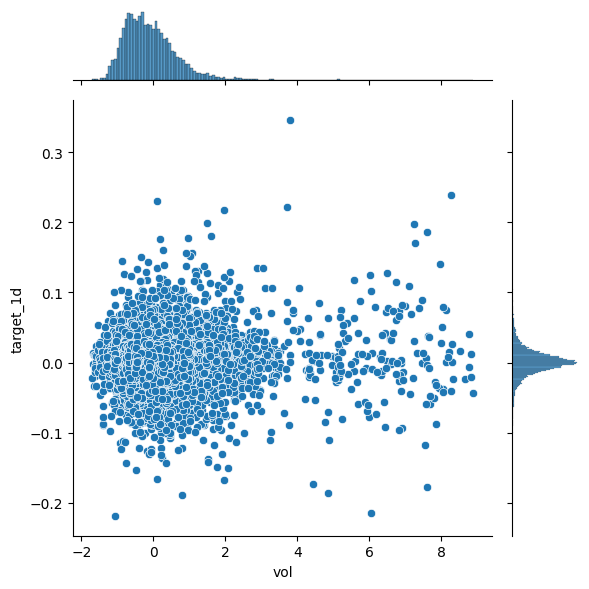

In [133]:
# 1일 목표 수익률을 target 변수에 할당
target = "target_1d"

# 변동성 지표를 metric 변수에 할당 
metric = "vol"

# seaborn의 jointplot을 사용하여 변동성과 목표 수익률의 산점도와 분포도를 함께 표시
j = sns.jointplot(x=metric, y=target, data=prices)

# 그래프 레이아웃 조정
plt.tight_layout()

Spearman 순위 상관관계와 p-값을 계산하고 표시

In [134]:
# metric과 target 열만 선택하고 결측치 제거
df = prices[[metric, target]].dropna()

metric과 target 열 표시

In [135]:
display(df[metric])
display(df[target])

symbol  date      
CDE     2015-01-22    0.502345
        2015-01-23    0.466274
        2015-01-26    0.512970
        2015-01-27    0.508157
        2015-01-28    0.488355
                        ...   
UNH     2022-12-22   -0.464863
        2022-12-23   -0.477275
        2022-12-27   -0.480026
        2022-12-28   -0.429139
        2022-12-29   -0.450629
Name: vol, Length: 16000, dtype: float64

symbol  date      
CDE     2015-01-22   -0.050713
        2015-01-23    0.020033
        2015-01-26    0.034370
        2015-01-27   -0.052215
        2015-01-28   -0.008347
                        ...   
UNH     2022-12-22    0.008006
        2022-12-23    0.001280
        2022-12-27   -0.006654
        2022-12-28    0.002706
        2022-12-29    0.000566
Name: target_1d, Length: 16000, dtype: float64

In [137]:
# Spearman 상관계수와 p-값 계산 
r, p = spearmanr(df[metric], df[target])

상관계수와 p값 표시

In [138]:
# 상관계수와 p-값을 백분율로 표시
display(f"{r:,.2%} ({p:.2%})")

'2.29% (0.38%)'

---
이 결과를 다음과 같이 해석할 수 있습니다:

1. **상관계수 (r = 2.29%)**
- 파킨슨 변동성(metric)과 1일 미래 수익률(target) 사이에 매우 약한 양의 상관관계가 있습니다
- 0에 매우 가까운 값으로, 두 변수 간의 관계가 거의 없음을 의미합니다
- 실무적으로는 변동성이 다음날 수익률을 예측하는데 거의 도움이 되지 않는다는 의미입니다

2. **p-값 (p = 0.38%)**
- p-값이 0.38%로, 일반적인 유의수준 5%보다 낮습니다
- 이는 관찰된 상관관계가 통계적으로 유의미하다는 것을 의미합니다
- 즉, 이 약한 상관관계가 우연히 발생했을 가능성이 매우 낮다는 것을 나타냅니다

3. **투자 관점의 해석**
- 통계적으로는 유의미하지만, 경제적으로는 의미가 거의 없는 수준의 관계입니다
- 이 정도의 약한 상관관계로는 실제 투자 전략을 구축하기 어렵습니다
- 거래 비용을 고려하면 수익성 있는 전략을 만들기 어려울 것으로 예상됩니다

4. **결론**
- 파킨슨 변동성은 다음날의 수익률을 예측하는데 실질적인 가치가 거의 없습니다
- 다른 예측 요인이나 더 긴 시간 프레임을 고려해볼 필요가 있습니다
---

### 작동 방식...

이 레시피에서는 요인 분석을 위해 데이터를 준비할 때 필요한 전처리 과정을 다룹니다.

히스토리컬 데이터가 포함된 데이터프레임을 MultiIndex로 설정하고, 인덱스의 레벨을 `symbol`이 먼저 오도록 재정렬한 후, 중복 행을 제거합니다. 이는 각 그룹에 정규화된 파킨슨 변동성을 적용할 수 있도록 합니다. 이를 위해 데이터프레임을 `symbol` 기준으로 그룹화하고, `apply` 메서드를 사용하여 사용자 정의 파킨슨 변동성 함수를 각 데이터 청크에 적용합니다.

마지막으로, 과거 및 미래 수익률을 계산합니다. 첫 번째 반복문에서 코드는 `lags` 리스트에 지정된 여러 기간에 대해 과거 수익률을 계산합니다. 이를 위해 데이터프레임을 `symbol`로 그룹화하고, 지정된 기간 동안의 백분율 변화를 계산합니다. 이렇게 계산된 과거 수익률은 `return_1d`, `return_5d` 등과 같은 이름의 새 열로 데이터프레임에 추가됩니다.

두 번째 반복문에서는 `lags` 리스트에 지정된 여러 기간에 대해 미래 수익률을 계산합니다. 이를 위해 이미 계산된 과거 수익률(`return_1d`, `return_5d` 등)을 사용하며, 지정된 기간만큼 데이터를 위로 이동시킵니다. 이 작업은 각 행에 미래에 발생할 수익률을 할당하는 것입니다. 이렇게 계산된 미래 수익률은 `target_1d`, `target_5d` 등과 같은 이름의 새 열로 데이터프레임에 추가됩니다.

---

### 더 알아보기...

`spearmanr` 함수는 두 데이터 배열 간의 스피어만 순위 상관계수를 계산합니다. SciPy 메서드를 사용하여 순위 상관계수와 p값을 얻을 수 있습니다:
```python
stat, pvalue = spearmanr(df[metric], df[target])
```

- `stat` 계수는 두 변수 간 관계의 강도와 방향을 측정하며, 값은 -1에서 1 사이입니다. 0은 상관관계가 없음을, 1은 완벽한 양의 상관관계를, -1은 완벽한 음의 상관관계를 나타냅니다.
- 이 문맥에서 `stat`는 파킨슨 변동성과 미래 수익률 간의 상관관계로, 0.0378의 약한 양의 상관관계를 가집니다.
- `pvalue`는 데이터가 상관관계가 없다는 귀무 가설을 검정합니다. 작은 p값(일반적으로 ≤ 0.05)은 귀무 가설을 기각할 수 있음을 나타냅니다. 이 경우, p값은 0.0158로, 귀무 가설을 기각할 수 있음을 나타내며, 이는 파킨슨 변동성과 해당 포트폴리오 수익률 간에 통계적으로 유의미한 상관관계가 있음을 시사합니다.

---

### 참고 자료

이 레시피에 사용된 도구 및 기술에 대한 추가 리소스는 아래 링크를 참조하세요:

- 파킨슨 변동성 워크스루: [https://www.ivolatility.com/help/3.html](https://www.ivolatility.com/help/3.html)
- 평균 진폭 범위: [https://en.wikipedia.org/wiki/Average_true_range](https://en.wikipedia.org/wiki/Average_true_range)
- 스피어만 순위 상관관계: [https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)
- SciPy의 스피어만 순위 상관계수 구현 문서: [https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html)

---

## Preparing a Factor Ranking Model Using Zipline Pipelines

In [52]:
import os
import warnings

In [54]:
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from zipline.data import bundles
from zipline.data.bundles.core import load
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.factors import (
    VWAP,
    AnnualizedVolatility,
    AverageDollarVolume,
    BollingerBands,
    CustomFactor,
    DailyReturns,
    ExponentialWeightedMovingAverage,
    MaxDrawdown,
    PercentChange,
    Returns,
    SimpleMovingAverage,
    WeightedAverageValue,
)
from zipline.pipeline.loaders import USEquityPricingLoader

In [55]:
warnings.filterwarnings("ignore")

### Option 1: Use the built-in bundle with free data

This option uses the built-in data bundle provided by Zipline. It then acquires free US equities data that extend through 2018.

In [57]:
os.environ["QUANDL_API_KEY"] = "zHU2bL4Z7NmqLNSjUZRn"
bundle = "quandl"
bundles.ingest(bundle)

Couldn't compute ratio for dividend sid=67, ex_date=2017-11-09, amount=0.620
Couldn't compute ratio for dividend sid=93, ex_date=2017-11-09, amount=0.240
Couldn't compute ratio for dividend sid=161, ex_date=2017-11-09, amount=0.110
Couldn't compute ratio for dividend sid=283, ex_date=2017-11-09, amount=0.415
Couldn't compute ratio for dividend sid=298, ex_date=2017-11-09, amount=1.420
Couldn't compute ratio for dividend sid=318, ex_date=2017-11-09, amount=0.330
Couldn't compute ratio for dividend sid=434, ex_date=2017-11-09, amount=0.110
Couldn't compute ratio for dividend sid=516, ex_date=1996-05-30, amount=0.310
Couldn't compute ratio for dividend sid=524, ex_date=2017-11-09, amount=0.050
Couldn't compute ratio for dividend sid=556, ex_date=2017-11-09, amount=0.075
Couldn't compute ratio for dividend sid=578, ex_date=2017-11-09, amount=0.160
Couldn't compute ratio for dividend sid=605, ex_date=2017-11-09, amount=0.040
Couldn't compute ratio for dividend sid=666, ex_date=1990-03-26, a

### Option 2: Use the custom bundle with premium data

This option uses the custom bundle with premium data. Follow the steps here: https://pyquantnews.com/ingest-premium-market-data-with-zipline-reloaded/ before using.

In [ ]:
# os.environ["DATALINK_API_KEY"] = "YOUR_API_KEY"
# bundle = "quotemedia"
# load_extensions(True, [], False, os.environ)
# bundles.ingest(bundle)

Ingest the bundle data from your selected bundle.

In [9]:
bundle_data = load(bundle, os.environ, None)

Create a USEquityPricingLoader

In [10]:
pipeline_loader = USEquityPricingLoader(
    bundle_data.equity_daily_bar_reader, bundle_data.adjustment_reader, fx_reader=None
)

Initialize a SimplePipelineEngine

In [11]:
engine = SimplePipelineEngine(
    get_loader=lambda col: pipeline_loader, asset_finder=bundle_data.asset_finder
)

Define a custom momentum factor

In [12]:
class MomentumFactor(CustomFactor):
    """Momentum factor"""

    inputs = [USEquityPricing.close, Returns(window_length=126)]
    window_length = 252

    def compute(self, today, assets, out, prices, returns):
        out[:] = (
            (prices[-21] - prices[-252]) / prices[-252]
            - (prices[-1] - prices[-21]) / prices[-21]
        ) / np.nanstd(returns, axis=0)

Define a function to create a pipeline

In [13]:
def make_pipeline():
    momentum = MomentumFactor()
    dollar_volume = AverageDollarVolume(window_length=30)

    return Pipeline(
        columns={
            "factor": momentum,
            "longs": momentum.top(50),
            "shorts": momentum.bottom(50),
            "rank": momentum.rank(),
        },
        screen=dollar_volume.top(100),
    )

Run the pipeline

In [14]:
results = engine.run_pipeline(
    make_pipeline(), pd.to_datetime("2012-01-04"), pd.to_datetime("2012-03-01")
)

Clean and display the results

In [15]:
results.dropna(subset="factor", inplace=True)
results.index.names = ["date", "symbol"]
results.sort_values(by=["date", "factor"], inplace=True)

In [ ]:
display(results)

In [63]:
import os
import numpy as np
import pandas as pd
from zipline.data import bundles
from zipline.data.bundles.core import load
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.factors import (
    CustomFactor,
    AverageDollarVolume,
)
from trading_calendars import get_calendar
from zipline.pipeline.loaders import USEquityPricingLoader

# Zipline 번들 데이터 불러오기
bundle_name = "quantopian-quandl"
try:
    bundles.ingest(bundle_name)
except Exception as e:
    print(f"Bundle ingestion failed: {e}")

bundle_data = load(bundle_name, os.environ, None)

pipeline_loader = USEquityPricingLoader(
    bundle_data.equity_daily_bar_reader, bundle_data.adjustment_reader
)

# SimplePipelineEngine 초기화
def get_loader(column):
    return pipeline_loader

engine = SimplePipelineEngine(
    get_loader=get_loader, asset_finder=bundle_data.asset_finder
)

# Custom Factor 정의
class MomentumFactor(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 252

    def compute(self, today, assets, out, close_prices):
        out[:] = (close_prices[-21] - close_prices[-252]) / close_prices[-252]

# Pipeline 생성 함수
def make_pipeline():
    momentum = MomentumFactor()
    dollar_volume = AverageDollarVolume(window_length=30)

    return Pipeline(
        columns={
            "momentum": momentum,
            "longs": momentum.top(50),
            "shorts": momentum.bottom(50),
        },
        screen=dollar_volume.top(100),
    )

# 파이프라인 실행
start_date = pd.Timestamp("2012-01-04", tz="utc")
end_date = pd.Timestamp("2012-03-01", tz="utc")
calendar = get_calendar("XNYS")

try:
    results = engine.run_pipeline(make_pipeline(), start_date, end_date)
    results.index.names = ["date", "asset"]
    print(results)
except Exception as e:
    print(f"Pipeline execution failed: {e}")


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NaTType'